# Machine Learning Project

## Table of Contents
- [Import Data](#import-data)
  - [Import Data Summary](#import-data-summary)
- [Data Exploration](#data-exploration)
  - [Boolean Features](#boolean-features)
    - [Boolean Features Analysis](#boolean-features-analysis)
  - [Categorical Features](#categorical-features)
    - [Check Categorical Features Consistency](#check-categorical-features-consistency)
    - [Categorical Features Summary](#categorical-features-summary)
  - [Numerical Features](#numerical-features)
    - [Numerical Plots](#plots)
    - [Analysis of Numerical Distributions](#analysis-of-numerical-distributions)
- [Pre-processing](#pre-processing)
  - [Functions](#functions)
  - [Split Data](#split-data)
    - [Target Transformation](#target-transformation)
  - [Outliers and Missing Values](#outliers-and-missing-values)
    - [Categorical Outliers and Missing Values](#categorical-outliers-and-missing-values)
    - [Numerical Outliers](#numerical-outliers)
    - [Numerical Missing Values](#numerical-missing-values)
- [Feature Engineering](#feature-engineering)
  - [Encode Features](#encode-features)
  - [Normalize Features](#normalize-features)
    - [Correlation Matrix](#correlation-matrix)
- [Model Training](#model-training)
  - [Baseline Model Training](#baseline-model-training)
  - [Experiment with Different Models](#experiment-with-different-models)
- [Predictions](#predictions)

<a id="import-data"></a>
## Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# to calculate distance between strings
import nltk

SEED = 42

In [2]:
df = pd.read_csv('data/train.csv').set_index('carID')
df.head()

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75973 entries, 69512 to 15795
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           74452 non-null  object 
 1   model           74456 non-null  object 
 2   year            74482 non-null  float64
 3   price           75973 non-null  int64  
 4   transmission    74451 non-null  object 
 5   mileage         74510 non-null  float64
 6   fuelType        74462 non-null  object 
 7   tax             68069 non-null  float64
 8   mpg             68047 non-null  float64
 9   engineSize      74457 non-null  float64
 10  paintQuality%   74449 non-null  float64
 11  previousOwners  74423 non-null  float64
 12  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 8.1+ MB


In [4]:
num_duplicated_ids = df.index.duplicated().sum()
print(f'Number of duplicated carIDs: {num_duplicated_ids}')

Number of duplicated carIDs: 0


<a id="import-data-summary"></a>
#### Import Data Summary
- Dataset loaded successfully with `carID` as the index
- There are no duplicate entries in carID
- The dataset contains information about cars including both numerical features (price, mileage, tax, etc.) and categorical features (brand, model, transmission, etc.)
- Initial inspection shows multiple features that will require preprocessing:
  - Numerical features that need cleaning (negative values, outliers)
  - Categorical features that need standardization
  - Presence of missing values in several columns

<a id="data-exploration"></a>
## Data Exploration

<a id="boolean-features"></a>
### Boolean Features

In [5]:
df['hasDamage'].value_counts(dropna=False)

hasDamage
0.0    74425
NaN     1548
Name: count, dtype: int64

<a id="boolean-features-analysis"></a>
#### Boolean Features Analysis

Key observations about `hasDamage` feature:
- Only contains binary values (0) and NaN
- No instances of value 1 found, suggesting potential data collection issues
- May indicate:
  - Cars with damage not being listed
  - System default setting of 0 for non-damaged cars
  - Incomplete damage assessment process
- Requires special handling in preprocessing:
  - Consider treating NaN as a separate category
  - Validate if 0 truly represents "no damage"
  - May need to be treated as a categorical rather than boolean feature

<a id="categorical-features"></a>
### Categorical Features

<a id="check-categorical-features-consistency"></a>
#### Check Categorical Features Consistency

In [6]:
# List of categorical features
cat_cols = ['Brand', 'model', 'fuelType', 'transmission']

# Identify outlier examples in categorical features
cat_outliers_examples = {col: df[col].value_counts().tail(10).index for col in cat_cols}

# Display the outlier examples
pd.DataFrame(cat_outliers_examples)

,Brand,model,fuelType,transmission
0,mercede,m3,Othe,utomati
1,kod,GOLF SV,ther,manual
2,AUD,Avensis,Electric,AUTOMATI
3,KODA,s-ma,YBRID,emi-Aut
4,HYUNDA,X4,OTHER,Other
5,OYOTA,m4,other,semi-aut
6,SKOD,yaris,HYBRI,manua
7,TOYOT,FOCUS,ybri,UTOMATIC
8,skod,arteon,ETRO,manual
9,toyot,glb class,IESE,nknow


<a id="categorical-features-summary"></a>
#### Categorical Features Summary
- Initial analysis reveals significant data quality issues across all categorical columns
- No standardization in categorical features, with multiple variations of the same values (different spellings, capitalizations)
- Solution: We will implement string distance-based standardization using the `thefuzz` library to clean and standardize these features

<a id="numerical-features"></a>
### Numerical Features

In [7]:
# Dict of numerical features
num_cols = {
    'price': 'continuous',
    'mileage': 'continuous',
    'tax': 'continuous',
    'mpg': 'continuous',
    'paintQuality%': 'continuous',
    'engineSize': 'continuous',
    'year': 'discrete',
    'previousOwners': 'discrete'
}

<a id="plots"></a>
#### Numerical Plots

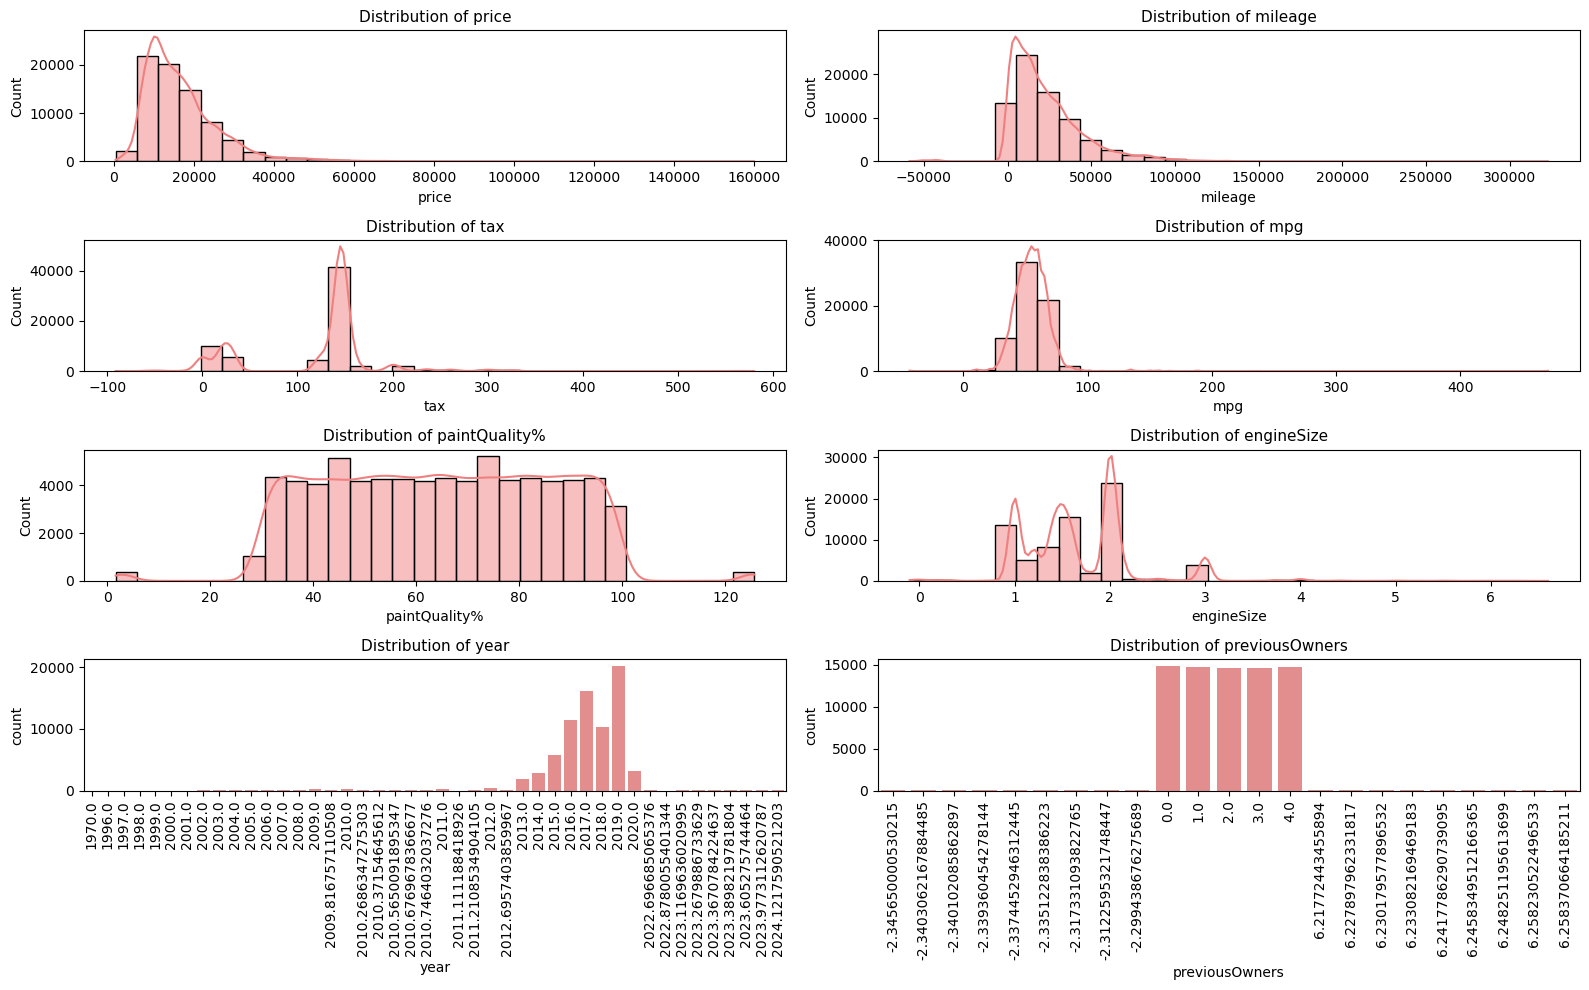

In [8]:
# Plot figures for numerical features and the target variable (price)
plt.figure(figsize=(16, 10))
for i, (col, var_type) in enumerate(num_cols.items(), 1):
    plt.subplot(4, 2, i)

    # Plot based on variable type
    if var_type == 'continuous':
        sns.histplot(data=df, x=col, kde=True, color="lightcoral", bins=30)
        plt.title(f"Distribution of {col}", fontsize=11)
    elif var_type == 'discrete':
        sns.countplot(data=df, x=col, color="lightcoral")
        plt.title(f"Distribution of {col}", fontsize=11)
        plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

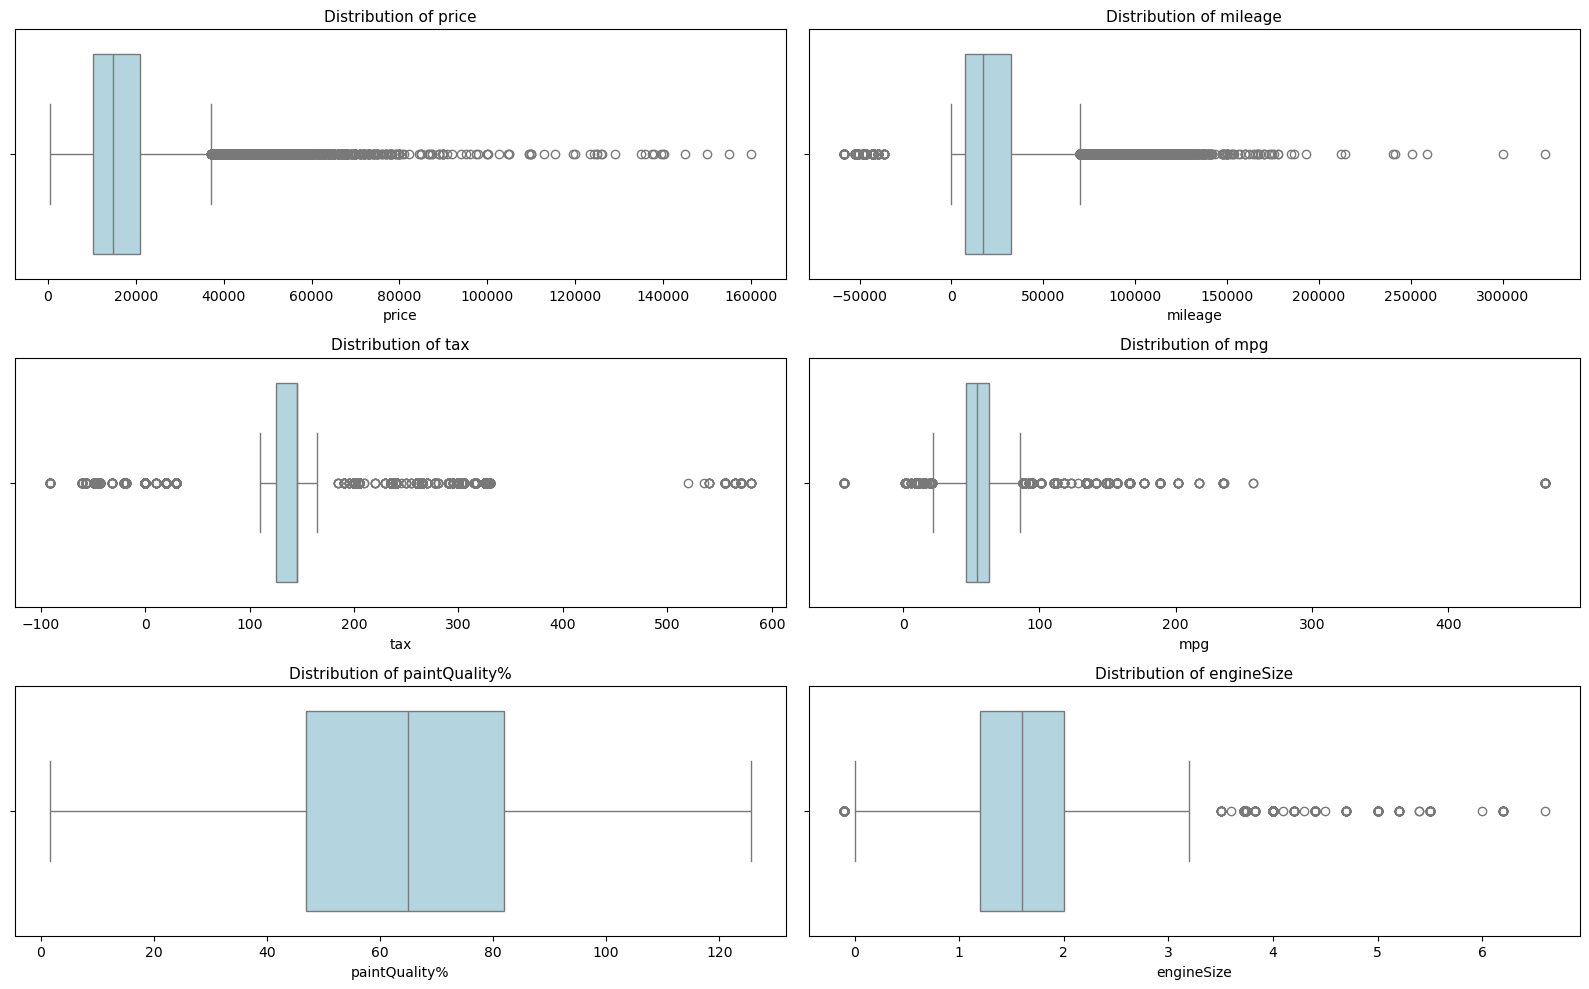

In [9]:
# Boxplots for continuous numerical features and the target variable (price)
continuous_cols = [col for col, var_type in num_cols.items() if var_type == 'continuous']
plt.figure(figsize=(16, 10))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x=col, color="lightblue")
    plt.title(f"Distribution of {col}", fontsize=11)

plt.tight_layout()
plt.show()

<a id="analysis-of-numerical-distributions"></a>
#### Analysis of Numerical Distributions

Key observations from the plots:
- **Target Variable (Price)**:
  - Highly right-skewed distribution
  - Contains significant number of outliers in the upper range
  - Most cars are concentrated in the lower price range

- **Mileage**:
  - Right-skewed distribution
  - Large range from nearly new cars to high-mileage vehicles
  - Some outliers in upper range suggesting possible data entry errors

- **Tax**:
  - Multiple peaks suggesting different tax bands
  - Contains negative values which require investigation (possible tax benefits/rebates)
  - Large number of outliers on both ends of the distribution

- **MPG (Miles Per Gallon)**:
  - Approximately normal distribution with slight right skew
  - Some unrealistic extreme values that need cleaning
  - Reasonable median around typical car efficiency ranges

- **Paint Quality %**:
  - Contains values above 100% which are logically impossible
  - Left-skewed distribution suggesting optimistic ratings
  - Requires standardization to 0-100 range

- **Engine Size**:
  - There are engine size with zero values which are not realistic (might indicate electric vehicles)
  - Some unusual patterns that need investigation
  - Contains outliers that may represent specialty vehicles

- **Year**:
  - Should be discrete but contains decimal values

- **Previous Owners**:
  - Should be integer but contains float values
  - Right-skewed distribution as expected
  - Maximum values need validation (unusually high number of previous owners)

<a id="pre-processing"></a>
## Pre-processing

<a id="functions"></a>
### Functions

In [10]:
def  general_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    """Perform general data cleaning on the DataFrame.
    
    This function handles logical inconsistencies and data quality issues that
    don't require statistical calculations (mean, median, etc.) to prevent data
    leakage between training and validation sets.
    
    Args:
        df (pd.DataFrame): The input DataFrame containing car data with columns:
            Brand, model, year, transmission, fuelType, mileage, tax, mpg, 
            engineSize, paintQuality%, previousOwners, hasDamage.
        
    Returns:
        pd.DataFrame: The cleaned DataFrame with logical inconsistencies resolved.
    """

    df = df.copy()

    # Set negative values to NaN for features that shouldn't be negative
    for col in ['previousOwners', 'mileage', 'tax', 'mpg', 'engineSize']:
        df.loc[df[col] < 0, col] = np.nan

    for col in ['Brand', 'model', 'transmission', 'fuelType']:
        df[col] = df[col].str.lower()
        df[col] = df[col].replace('', np.nan)

    # Remove decimal part from 'year'
    df['year'] = np.floor(df['year']).astype('Int64')

    # Remove decimal part from 'previousOwners'
    df['previousOwners'] = np.floor(df['previousOwners']).astype('Int64')

    # Ensure 'paintQuality%' is within 0-100
    df.loc[(df['paintQuality%'] < 0) | (df['paintQuality%'] > 100), 'paintQuality%'] = np.nan

    # Fill missing 'hasDamage' with 1
    df['hasDamage'] = df['hasDamage'].fillna(1).astype('Int64')

    return df

In [11]:
def standardize_categorical_col(series: pd.Series, 
                                standardised_cats: list[str], 
                                distance_threshold: int = 2) -> pd.Series:
    """Standardizes a categorical column using edit distance with a threshold.

    1. Maps values to a standard category if they are a likely typo
       (i.e., within the edit distance_threshold).
    2. Keeps values that are already in the standard list.
    3. Groups all other values that don't match into an 'other' bin.
    
    Args:
        series (pd.Series): The categorical column to standardize.
        standardised_cats (list[str]): The list of "good" categories to match against.
        distance_threshold (int): The max edit distance to consider something a typo.
                                  A value of 1 or 2 is recommended.
                                  
    Returns:
        pd.Series: The standardized categorical column.
    """
    
    # 1. Get all unique non-null values from the series
    unique_values = series.dropna().unique()
    
    # 2. Build the mapping dictionary
    mapping = {}
    
    for x in unique_values:
        x_str = str(x)
        
        # Check if it's already a perfect match
        if x_str in standardised_cats:
            mapping[x] = x_str
            continue

        # Find the closest match and its distance
        distances = [nltk.edit_distance(x_str, cat) for cat in standardised_cats]
        min_distance = np.min(distances)
        
        if min_distance <= distance_threshold:
            closest_cat = standardised_cats[np.argmin(distances)]
            mapping[x] = closest_cat
        else:
            mapping[x] = 'other'
            
    return series.map(mapping)

In [12]:
def get_categories_high_freq(series: pd.Series, percent_threshold: float = 0.02) -> list[str]:
    """Get categories that appear more than a dynamic percentage threshold.
    
    Args:
        series (pd.Series): The categorical series to analyze.
        percent_threshold (float): The minimum percentage of total rows a category
                                   must have to be included (e.g., 0.01 for 1%).
                                   
    Returns:
        list[str]: List of categories with frequency above the dynamic threshold.
    """
    
    # Calculate the dynamic count threshold based on the percentage
    dynamic_count_threshold = len(series) * percent_threshold
    
    value_counts = series.value_counts()
    
    # Use the *same logic* as before, but with the new dynamic threshold
    high_freq_cats = value_counts[value_counts > dynamic_count_threshold].index.tolist()
    
    return high_freq_cats

In [13]:
def calculate_upper_bound(series: pd.Series) -> float:
    """Calculates the upper outlier bound for a pandas Series."""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return Q3 + (1.5 * IQR)

In [14]:
def clean_outliers(series: pd.Series, 
                   upper_bound: float,
                   lower_bound: float = 0.0, 
                   return_missing: bool = True) -> pd.Series:
    """Clean outliers in the Series based on specified bounds.

    This function clips values outside the specified bounds or sets them to NaN.
    
    Args:
        series (pd.Series): The input Series containing numerical data.
        lower_bound (float): The lower bound for valid values.
        upper_bound (float): The upper bound for valid values.
        return_missing (bool): If True, set out-of-bound values to NaN.
                              If False, clip values to the bounds.
    
    Returns:
        pd.Series: The cleaned Series with outliers handled.
    """
    cleaned = series.copy()
    
    if return_missing:
        # Set out-of-bound values to NaN
        cleaned[(cleaned < lower_bound) | (cleaned > upper_bound)] = np.nan
    else:
        # Clip values to the specified bounds
        cleaned = cleaned.clip(lower=lower_bound, upper=upper_bound)
    
    return cleaned


<a id="split-data"></a>
### Split Data

In [15]:
# Apply general cleaning to the entire dataset, before splitting
df_cleaned = general_cleaning(df)

# Split the cleaned data into training and validation sets
X = df_cleaned.drop(columns=["price"])   
y = df_cleaned["price"]
del num_cols['price']
continuous_cols.remove('price')

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED
)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")


Training set size: (60778, 12)
Validation set size: (15195, 12)


<a id="target-transformation"></a>
#### Target Transformation

Apply log transformation to the target variable (price) to:
- Reduce skewness in the distribution
- Handle wide price ranges more effectively
- Stabilize variance
- Improve model performance

We use `np.log1p()` which computes log(1 + x) to handle any zero values safely.

In [16]:
# Apply log transformation to target variable
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

print(f"Original y_train range: £{y_train.min():.2f} - £{y_train.max():.2f}")
print(f"Log-transformed y_train range: {y_train_log.min():.4f} - {y_train_log.max():.4f}")

Original y_train range: £450.00 - £159999.00
Log-transformed y_train range: 6.1115 - 11.9829


<a id="outliers-and-missing-values"></a>
### Outliers and Missing Values

<a id="categorical-outliers-and-missing-values"></a>
#### Categorical Outliers and Missing Values

In [17]:
# map of categorical columns to their high frequency categories
# Using only the categories in train
high_freq_categories_by_col = {col: get_categories_high_freq(X_train[col]) for col in cat_cols}

for col in cat_cols:
    standardised_cats = high_freq_categories_by_col[col]
    # process training data
    X_train[col] = standardize_categorical_col(X_train[col], standardised_cats)
    X_train[col] =X_train[col].fillna('other')
    
    # process validation data
    X_val[col] = standardize_categorical_col(X_val[col], standardised_cats)
    X_val[col] = X_val[col].fillna('other')

<a id="numerical-outliers"></a>
#### Numerical Outliers

In [18]:
# Mileage is right_skewed and extremes might exist
mileage_upper_bound = X_train['mileage'].quantile(0.95)

# Calculate upper bounds for each continuous numerical feature (excluding price - it's the target)
continuous_cols_for_outliers = [col for col in continuous_cols if col != 'price']
upper_bounds_num_cols = {col: calculate_upper_bound(X_train[col]) for col in continuous_cols_for_outliers}

# Winsorization at 95th percentile for mileage
X_train['mileage'] = clean_outliers(X_train['mileage'], 
                                     lower_bound=0, 
                                     upper_bound=mileage_upper_bound, 
                                     return_missing=False)

X_val['mileage'] = clean_outliers(X_val['mileage'], 
                                     lower_bound=0, 
                                     upper_bound=mileage_upper_bound, 
                                     return_missing=False)

# Turn outliers for remaining columns into np.nan
for col in continuous_cols_for_outliers:
    if col == 'mileage':
        continue
    upper_bound = upper_bounds_num_cols[col]
    
    X_train[col] = clean_outliers(X_train[col], upper_bound)
    X_val[col] = clean_outliers(X_val[col], upper_bound)

<a id="numerical-missing-values"></a>
#### Numerical Missing Values

In [19]:
median_num_cols = {col: X_train[col].median() for col in num_cols}

for col in num_cols:
    calc_median = median_num_cols[col]
    X_train[col] = X_train[col].fillna(calc_median)
    X_val[col] = X_val[col].fillna(calc_median)


<a id="feature-engineering"></a>
# Feature Engineering

<a id="encode-features"></a>
## Encode Features

In [20]:
categorical_features = cat_cols
numeric_features = list(num_cols.keys()) 

In [21]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ohe_train = pd.DataFrame(
    ohe.fit_transform(X_train[categorical_features]),
    columns=ohe.get_feature_names_out(categorical_features),
    index=X_train.index
)

In [22]:
ohe_val = pd.DataFrame(
    ohe.transform(X_val[categorical_features]),
    columns=ohe.get_feature_names_out(categorical_features),
    index=X_val.index
)

In [23]:
X_train = pd.concat([X_train.drop(columns=categorical_features), ohe_train], axis=1)
X_val   = pd.concat([X_val.drop(columns=categorical_features),   ohe_val],   axis=1)

<a id="normalize-features"></a>
## Normalize Features

In [24]:
scaler = StandardScaler()

# Get numerical column names (exclude OHE columns)
numerical_cols = list(num_cols.keys())

# Fit scaler on training data and transform both sets
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])

print(f"Normalized {len(numerical_cols)} numerical features")
print(f"Feature names: {numerical_cols}")

Normalized 7 numerical features
Feature names: ['mileage', 'tax', 'mpg', 'paintQuality%', 'engineSize', 'year', 'previousOwners']


<a id="correlation-matrix"></a>
### Correlation Matrix for Numerical Features

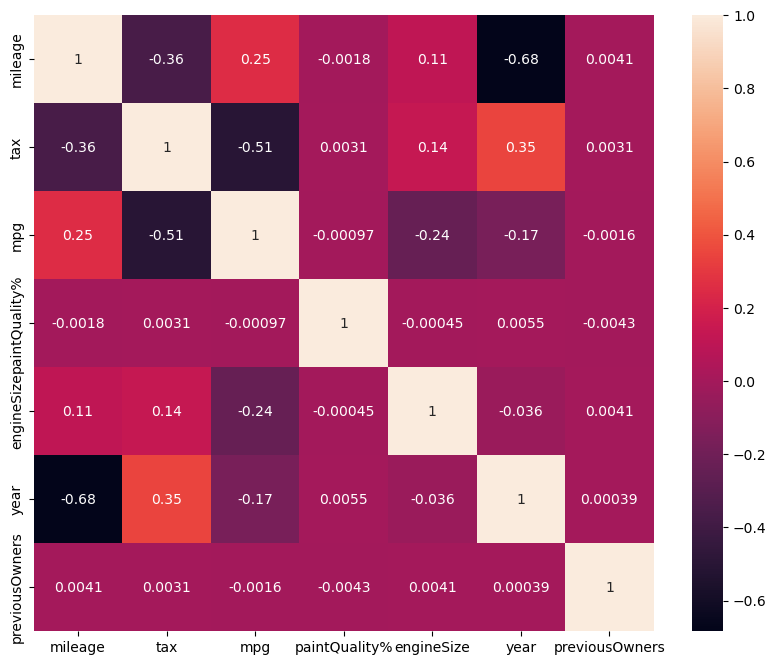

In [25]:
fig = plt.figure(figsize=(10, 8))
corr = X_train[list(num_cols.keys())].corr(method="pearson")
sns.heatmap(data=corr, annot=True, )


plt.show()

#### Observations
- Most correlations are weak, meaning variables are largely independent

---

##### Insights

**Mileage vs Year (-0.68)**
- Newer cars (higher `year`) tend to have lower mileage.
- These two features describe similar aspects of car age/usage.

**Tax vs mpg (-0.51)**
- Cars with better fuel efficiency (higher mpg) tend to have lower taxes, likely due to emissions-based tax systems.

**Tax vs Year (0.35)**
- **Weak positive correlation.**
- Newer cars may have slightly higher taxes, possibly reflecting newer model valuations or updated emission standards.

**Mileage vs mpg (0.25)**
- **Weak positive correlation.**
- Slightly counterintuitive — could suggest that cars with better mpg are driven more (used as daily vehicles).


**Other variables**
- `paintQuality%`, `engineSize`, and `previousOwners` show very low correlations (~ 0) with other variables.  
- These likely capture unique information and should be kept for modeling.




<a id="model-training"></a>
# Model Training

<a id="baseline-model-training"></a>
## Baseline Model Training

In [26]:
# Train model on log-transformed target
baseline_model = Ridge(fit_intercept = False)
baseline_model.fit(X_train, y_train_log)

,alpha,1.0
,fit_intercept,False
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [27]:
# Predictions and metrics
y_train_pred = np.expm1(baseline_model.predict(X_train))
y_val_pred = np.expm1(baseline_model.predict(X_val))

mae_train, mae_val = mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_val, y_val_pred)
rmse_train, rmse_val = root_mean_squared_error(y_train, y_train_pred), root_mean_squared_error(y_val, y_val_pred)
r2_train, r2_val = r2_score(y_train, y_train_pred), r2_score(y_val, y_val_pred)

print(f"Baseline - Train: MAE=£{mae_train:.2f}, RMSE=£{rmse_train:.2f}, R²={r2_train:.4f}")
print(f"Baseline - Val:   MAE=£{mae_val:.2f}, RMSE=£{rmse_val:.2f}, R²={r2_val:.4f}")

# Store baseline metrics for comparison
baseline_metrics = {
    'mae_train': mae_train,
    'mae_val': mae_val,
    'rmse_train': rmse_train,
    'rmse_val': rmse_val,
    'r2_train': r2_train,
    'r2_val': r2_val
}

Baseline - Train: MAE=£2565.30, RMSE=£4810.68, R²=0.7583
Baseline - Val:   MAE=£2519.30, RMSE=£4361.97, R²=0.7911


<a id="experiment-with-different-models"></a>
## Experiment with Different Models

In [28]:
def train_evaluate_model(model, name, baseline_metrics=None):
    """
    Fit model on log-transformed target and evaluate performance.
    
    Args:
        model: sklearn model instance to train and evaluate
        name: str, display name for the model
        baseline_metrics: dict, optional baseline metrics for comparison
                         (keys: 'mae_val', 'r2_val', etc.)
    
    Returns:
        dict: metrics containing MAE, RMSE, and R² for train and validation sets
    """
    model.fit(X_train, y_train_log)
    
    y_train_pred = np.expm1(model.predict(X_train))
    y_val_pred = np.expm1(model.predict(X_val))
    
    mae_t, mae_v = mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_val, y_val_pred)
    rmse_t, rmse_v = root_mean_squared_error(y_train, y_train_pred), root_mean_squared_error(y_val, y_val_pred)
    
    print(f"\n{name}")
    print(f"  Train: MAE=£{mae_t:.2f}, RMSE=£{rmse_t:.2f}")
    print(f"  Val:   MAE=£{mae_v:.2f}, RMSE=£{rmse_v:.2f}")
    
    if baseline_metrics:
        mae_diff = mae_v - baseline_metrics['mae_val']
        status = "Better" if mae_diff < 0 else "Worse" if mae_diff > 0 else "Same"
        print(f"  vs Baseline: MAE {mae_diff:+.2f} - {status}")
    
    return model

In [29]:
lasso = train_evaluate_model(
    Lasso(alpha=0.1),
    "Lasso Regression",
    baseline_metrics
)



Lasso Regression
  Train: MAE=£4271.93, RMSE=£7045.75
  Val:   MAE=£4195.60, RMSE=£6651.34
  vs Baseline: MAE +1676.30 - Worse


In [30]:
linear_regression_model = train_evaluate_model(
    LinearRegression(),
    "Linear Regression",
    baseline_metrics
)



Linear Regression
  Train: MAE=£2565.88, RMSE=£4810.84
  Val:   MAE=£2519.94, RMSE=£4362.35
  vs Baseline: MAE +0.64 - Worse


In [31]:
random_forest_model_raw = train_evaluate_model(
    RandomForestRegressor(random_state=SEED),
    "Random Forest Regressor (raw)",
    baseline_metrics
)


Random Forest Regressor (raw)
  Train: MAE=£578.56, RMSE=£1155.20
  Val:   MAE=£1534.29, RMSE=£2597.09
  vs Baseline: MAE -985.01 - Better


In [32]:
model = random_forest_model_raw

### Model Selection Conclusion

The selected model shows some signs of overfitting, with better training performance compared to validation (Train MAE < Val MAE). However even on the validation set, the metrics demonstrate good performance, compared to the baseline

<a id="predictions"></a>
# Predictions

In [33]:
test_df = pd.read_csv('data/test.csv').set_index('carID')
test_df_cleaned = general_cleaning(test_df)
test_df_cleaned.head()


,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
89856,hyundai,i30,2022,automatic,30700.0,petrol,205.0,41.5,1.6,61.0,3,0
106581,vw,tiguan,2017,semi-auto,NaN,petrol,150.0,38.2,2.0,60.0,2,0
80886,bmw,2 series,2016,automatic,36792.0,petrol,125.0,51.4,1.5,94.0,2,0
100174,opel,grandland x,2019,manual,5533.0,petrol,145.0,44.1,1.2,77.0,1,0
81376,bmw,1 series,2019,semi-auto,9058.0,diesel,150.0,51.4,2.0,45.0,4,0


In [34]:
for col in cat_cols:
    standardised_cats = high_freq_categories_by_col[col]
    # process training data
    test_df_cleaned[col] = standardize_categorical_col(test_df_cleaned[col], standardised_cats)
    test_df_cleaned[col] = test_df_cleaned[col].fillna('other')

In [35]:
# Apply mileage winsorization using the TRAINING upper bound
test_df_cleaned['mileage'] = clean_outliers(
    test_df_cleaned['mileage'], 
    lower_bound=0, 
    upper_bound=mileage_upper_bound,  # From training data
    return_missing=False
)

In [36]:
# Turn outliers for remaining columns into np.nan (using same list as training)
continuous_cols_for_outliers = [col for col in continuous_cols if col != 'price']
for col in continuous_cols_for_outliers:
    if col == 'mileage':
        continue
    upper_bound = upper_bounds_num_cols[col]
    
    test_df_cleaned[col] = clean_outliers(test_df_cleaned[col], upper_bound)

In [37]:
# Fill missing values using TRAINING medians
for col in num_cols:
    calc_median = median_num_cols[col]  # Get the median from training data
    test_df_cleaned[col] = test_df_cleaned[col].fillna(calc_median)

In [38]:
ohe_test = pd.DataFrame(
    ohe.transform(test_df_cleaned[categorical_features]),
    columns=ohe.get_feature_names_out(categorical_features),
    index=test_df_cleaned.index
)

test_df_cleaned = pd.concat([test_df_cleaned.drop(columns=categorical_features), ohe_test], axis=1)

In [39]:
# Apply StandardScaler normalization using training statistics
test_df_cleaned[numerical_cols] = scaler.transform(test_df_cleaned[numerical_cols])

In [40]:
# Make predictions (in log space) and inverse transform to original scale
test_df_cleaned['price'] = np.expm1(model.predict(test_df_cleaned))

In [41]:
test_df_cleaned['price'].to_csv('data/test_predictions.csv')